# Get The Data Ready

In [ ]:

import pandas as pd 
df = pd.read_csv('/content/data.csv')


train validarion split

In [ ]:

from sklearn.model_selection import train_test_split
X_train , X_val , y_train , y_val = train_test_split(
    df.index.values,
    df.label.values,
    test_size = 0.15 , 
    random_state = 17,
    stratify = df.label.values
)


In [ ]:
df['data_type'] = ['not_set'] *df.shape[0]

In [ ]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
df.groupby([  'label' , 'data_type']).count()

Unnamed: 0  text  tokens  subjectivity  polarity  \
label       data_type                                                     
bullying    train            1317  1317    1317          1317      1317   
            val               232   232     232           232       232   
nonbullying train            1233  1233    1233          1233      1233   
            val               218   218     218           218       218   

                       Analysis  
label       data_type            
bullying    train          1317  
            val             232  
nonbullying train          1233  
            val             218

In [ ]:
labels = [ 'nonbullying','bullying']

In [ ]:
label_dic = {}
for index,label in enumerate(labels):
  label_dic[label] = index

In [ ]:
label_dic

{'nonbullying': 0, 'bullying': 1}

In [ ]:
df['label'] = df.label.replace(label_dic)

# Encoding Our Data

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import pandas as pd
from tqdm.notebook import tqdm
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import TensorDataset


In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')




In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type == 'train'].text.values,
    add_special_tokens = True ,
    return_attention_mask = True,
    pad_to_max_length = True,
    max_length = 256,
    return_tensors = 'pt'

)
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type == 'val'].text.values,
    add_special_tokens = True ,
    return_attention_mask = True,
    pad_to_max_length = True,
    max_length = 256,
    return_tensors = 'pt'

)


input_ids_train  = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].label.values)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Pytorch Dataset

In [ ]:
dataset_train = TensorDataset(input_ids_train,
                              attention_masks_train,
                              labels_train)
dataset_val = TensorDataset(input_ids_val,
                              attention_masks_val,
                              labels_val)

# **Setting** up the Model

In [ ]:
model = BertForSequenceClassification .from_pretrained('bert-base-uncased',
                                                            num_labels=len(label_dic),
                                                            output_attentions=False,
                                                            output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

## Creating Data Loader

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:
batch_size = 32
dataloader_train = DataLoader  ( 
    dataset_train ,
    sampler = RandomSampler(dataset_train),
    batch_size = batch_size

)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size = 32

)

# Setting Up Optimizer and Scheduler

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
optimizer = AdamW(
    model.parameters(),
    lr=5e-5, #2e-5 > 5e-5
    eps=1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 10
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = len(dataloader_train)*epochs
)

# Defining our Performance Metrics

Defining our Performance Metrics

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
def f1_score_func(preds, labels):
  preds_flat = np.argmax(preds , axis = 1).flatten()
  labels_flat = labels.flatten()
  return f1_score(labels_flat , preds_flat , average  ='weighted')

In [ ]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v : k for k , v in label_dic.items()}

    preds_flat = np.argmax(preds , axis = 1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
      y_preds = preds_flat[labels_flat == label]
      y_true = labels_flat[labels_flat == label]
      print(f'Class: {label_dict_inverse[label]}')
      print(f'Accuracy: {len(y_preds[y_preds == label])}/{len(y_true)}\n')

# Creating our Training Loop

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [ ]:
import numpy as np
from sklearn.metrics import classification_report


def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

            
    return loss_val_avg, predictions, true_vals

In [ ]:
loss_values = []
val_loss_values = []
training_times = []
testing_times = []
hist = [] 
import time


from jax._src import config
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report , confusion_matrix
hist = [{} for _ in range(epochs) ]
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0 
    progress_bar = tqdm(dataloader_train 
                        , desc='Epoch{:1d}'.format(epoch)
                        , leave=False,
                        disable = False)
    start_time = time.time()


    for batch in progress_bar:
      model.zero_grad()

      batch = tuple(b.to(device) for b in batch)

      inputs = {
          'input_ids'  : batch[0],
          'attention_mask' : batch[1],
          'labels'    : batch[2]
      }
      outputs = model(**inputs)
      loss = outputs[0]
      loss_train_total += loss.item()
      
     
      loss.backward()
      loss_values.append(loss.item()/len(batch))

      torch.nn.utils.clip_grad_norm_(model.parameters() , 1.0)

      optimizer.step()
      scheduler.step()

      progress_bar.set_postfix({'training_loss' : '{:.3f}'.format(loss.item()/len(batch)
      )})
    end_time = time.time()
    train_time = end_time - start_time
    training_times.append(train_time)


   # torch.save(model.state_dict() , f'/content/drive/MyDrive/models/Roberta{epoch}.model')
    tqdm.write(f'\nEpoch {epoch}')
    val_loss , predictions , true_vals = evaluate(dataloader_val)
    val_loss_values.append(val_loss)

    print(f'Validation loss: {val_loss}')
  
    # Calculate validation metrics
    class_predictions = np.argmax(predictions, axis=1)
    confusion = confusion_matrix(true_vals, class_predictions)

    report = classification_report(true_vals, class_predictions)  
    print(f'train_time:\n{train_time}')
    print(f'Validation metrics:\n{report}')

    tqdm.write(f'Confusion matrix:\n{confusion}')
    end_time = time.time()
    test_time = end_time - start_time
    testing_times.append(test_time)
    print(f'test_time:\n{test_time}')

    accuracy = accuracy_per_class(predictions , true_vals)
    hist.append({
        'epochIndex': epoch,
        'loss': loss.item(),
        'val_loss': val_loss,
        'classification_report': report,
        'conf_matrix': confusion,
        'accuracy': accuracy
    })

    

    

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch1:   0%|          | 0/638 [00:00<?, ?it/s]


Epoch 1
Validation loss: 0.2594354296879222
Validation metrics:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       218
           1       0.91      0.97      0.94       232

    accuracy                           0.94       450
   macro avg       0.94      0.94      0.94       450
weighted avg       0.94      0.94      0.94       450

Confusion matrix:
[[197  21]
 [  7 225]]
Class: nonbullying
Accuracy: 197/218

Class: bullying
Accuracy: 225/232



Epoch2:   0%|          | 0/638 [00:00<?, ?it/s]


Epoch 2
Validation loss: 0.25486959704818823
Validation metrics:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       218
           1       0.91      0.97      0.94       232

    accuracy                           0.93       450
   macro avg       0.94      0.93      0.93       450
weighted avg       0.93      0.93      0.93       450

Confusion matrix:
[[196  22]
 [  8 224]]
Class: nonbullying
Accuracy: 196/218

Class: bullying
Accuracy: 224/232



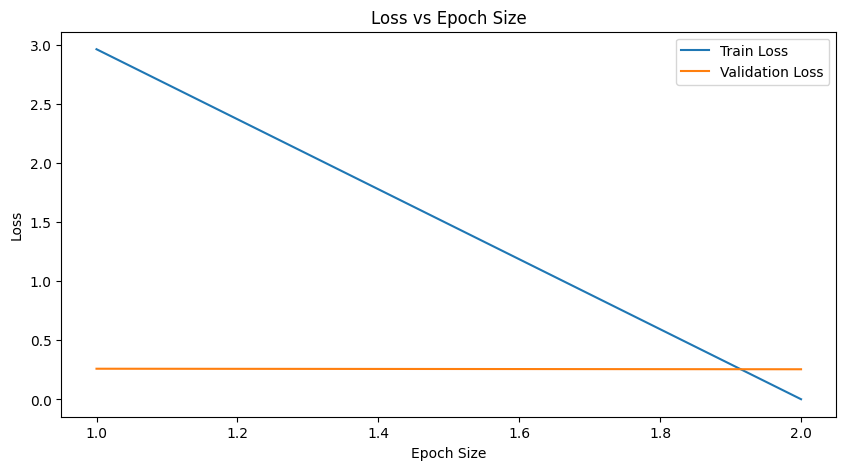

In [ ]:

# Loss GRAPH
train_losses = [hist[i]['loss'] for i in range(2, epochs+2)]
val_losses = [hist[i]['val_loss'] for i in range(2, epochs+2)]

# Accuracy değerlerini alın
train_accuracies = [hist[i]['accuracy'] for i in range(2, epochs)]

# Loss vs Epoch Size grafiğini çizin
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch Size')
plt.ylabel('Loss')
plt.title('Loss vs Epoch Size')
plt.legend()
plt.show()



In [ ]:
avg_train_time = sum(training_times) / len(training_times)
avg_test_time = sum(testing_times) / len(testing_times)
print(f'Average Training Time: {avg_train_time:.2f} seconds')
print(f'Average Testing Time: {avg_test_time:.2f} seconds')

In [ ]:
val_loss , predictions , true_vals = evaluate(dataloader_val)
class_predictions = np.argmax(predictions, axis=1)

report = classification_report(true_vals, class_predictions)


# Print the classification report
print("Classification Report:")
print(report) 